In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLP

import torch
import torchsde
from torch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM
from fab.target_distributions import gmm

from src.energies.base_prior import Prior, MeanFreePrior

from src.models.components.clipper import Clipper

from torch.func import hessian
from math import sqrt
from src.utils.data_utils import remove_mean

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [123]:
dimensionality = 2
temperature = 4.0
annealed_temperature = 1.0
inverse_temperature = temperature / annealed_temperature # beta in the paper


target = GMM(dimensionality=dimensionality,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True,
             temperature=temperature
             )

## Function Definitions

In [5]:
def rademacher(shape, dtype=torch.float32, device='cuda'):
    """Sample from Rademacher distribution."""
    rand = ((torch.rand(shape) < 0.5)) * 2 - 1
    return rand.to(dtype).to(device)

In [6]:
def _compute_laplacian_hutchinson(nabla_Ut, t, xt):
    # Compute the noise
    noise = rademacher(xt.shape, dtype=torch.float32, device=device)
    # Compute the jvp of the nabla_Ut and the noise
    jvp = torch.autograd.grad(nabla_Ut, xt, noise, create_graph=True)[0] # nabla(nabla_Ut) * noise
    laplacian = (jvp * noise).sum(-1)
    return laplacian.detach()


def compute_laplacian_hutchinson(nabla_Ut, t, xt, n_samples):
    laplacian = 0
    for _ in range(n_samples):
        laplacian += _compute_laplacian_hutchinson(nabla_Ut, t, xt)
    return laplacian / n_samples

In [7]:
def compute_laplacian(model, target, t, xt, noise_schedule): 
    def func_wrap(t, xt):
        return model(target, xt.unsqueeze(0), t.unsqueeze(0), noise_schedule).squeeze()

    # Calculate the Hessian matrix of the model output with respect to the input
    hessian_matrix = vmap(torch.func.jacrev(func_wrap, argnums=1))(t, xt)

    # Calculate the Laplacian as the trace of the Hessian matrix
    laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return laplacian.detach()

In [8]:
def true_Ut(target, x, t, noise_schedule):
    h_t = noise_schedule.h(t).to(device) #[0]
    target.gmm.convolve(h_t * (target.data_normalization_factor **2), t)
    energy = target(x)
    target.gmm.reset()
    return energy

In [9]:
def true_nabla_Ut(target, x, t, noise_schedule):
    nabla_Ut = torch.func.jacrev(true_Ut, argnums=1)(target, x, t, noise_schedule)
    return nabla_Ut

In [10]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    bins = torch.cumsum(torch.softmax(logits, dim=-1), dim=-1)
    ids = np.digitize(u, bins.cpu())
    ids = torch.tensor(ids, dtype=torch.long).to(device)
    return ids, next_u


def sample_cat_sys(bs, logits):
    u = torch.rand(size=(1,))
    u = (u + 1/bs*torch.arange(bs)) % 1
    bins = torch.cumsum(torch.softmax(logits, dim=-1), dim=-1)
    ids = np.digitize(u, bins.cpu())
    return ids, None

### SDEs

In [75]:
class VEReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, noise_schedule):
        super().__init__()
        self.noise_schedule = noise_schedule

    def f(self, t, x, resampling_interval=None, inverse_temperature=1.0):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            # target = GMM(dimensionality=2,
            # n_mixes=40,
            # loc_scaling= 40,
            # log_var_scaling=1.0,
            # device=device,
            # should_unnormalize=True,
            # temperature=temperature
            # )

            x.requires_grad_(True)
            t.requires_grad_(True)

            nabla_Ut = torch.vmap(true_nabla_Ut, in_dims=(None, 0, 0, None))(target, x, t, self.noise_schedule)
            drift_X = nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)

            if resampling_interval is None:
                return  drift_X, drift_A
            
            drift_A = - 0.5 * ((self.g(t, x)[:,None] * nabla_Ut).pow(2).sum(-1) 
                             * (inverse_temperature-1) * inverse_temperature)
                             
            # drift_A = 0.5 * ((self.g(t, x)[:,None] * nabla_Ut).pow(2).sum(-1) 
            #                  * (inverse_temperature-1) * inverse_temperature)

        return  drift_X.detach(), drift_A.detach()

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

### Integrators

In [ ]:
def euler_maruyama_step_coupled(sde, x, t, a, dt, step, resampling_interval,
                                inverse_temperature, u_next):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At = sde.f(t, x, resampling_interval, inverse_temperature)

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + inverse_temperature * drift_Xt * dt + diffusion
    # x_next = x + drift_Xt * dt + diffusion
    a_next = a + drift_At * dt

    if resampling_interval is None or step % resampling_interval != 0:
        return x_next, a_next, u_next

    #resample based on the weights
    # choice = torch.multinomial(torch.softmax(a_next, dim=-1), x.shape[0], replacement=True)
    # a_next = torch.zeros_like(a_next)
    # x_next = x_next[choice]
    # print("resampling")
    choice, _ = sample_cat_sys(x.shape[0], a_next)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next, u_next


def integrate_sde_coupled(sde, x0, t_span, dt, resampling_interval, inverse_temperature):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    u_next = 0.5
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a, u_next = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step+1, resampling_interval,
                                                       inverse_temperature, u_next)
            if target.is_molecule:
                x = remove_mean(x, target.n_particles, target.n_spatial_dim)
            samples.append(x)
            logweights.append(a)
    return torch.stack(samples), torch.stack(logweights)


def generate_samples_weighted(reverse_sde, t_span=(0, 1), num_integration_steps=100,
                              samples=None, num_samples=200, resampling_interval=None,
                              inverse_temperature=1.0, prior=None):
    integrator = integrate_sde_coupled
    if samples is None:
        if prior is None:
            # throw an exception
            raise ValueError("Either samples or prior distribution should be provided")
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights = integrator(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        resampling_interval = resampling_interval,
        inverse_temperature=inverse_temperature
    )
    return samples[-1], weights

### Sampling

In [91]:
from src.models.components.noise_schedules import GeometricNoiseSchedule, QuadraticNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.1, sigma_max=1.5 * sqrt(temperature))

#noise_schedule = QuadraticNoiseSchedule(beta=10)

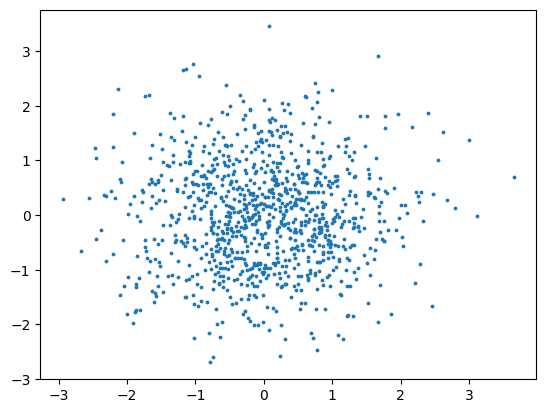

In [92]:
prior = Prior(2, device=device, scale = noise_schedule.h(1) ** 0.5)
annealed_prior = Prior(2, device=device, scale = (noise_schedule.h(1) / inverse_temperature) ** 0.5)
x1_samples = prior.sample(1000).detach()
plt.scatter(x1_samples[:, 0].cpu(), x1_samples[:, 1].cpu(), s=3)

times tensor([0.0000e+00, 5.0000e-04, 1.0000e-03,  ..., 9.9850e-01, 9.9900e-01,
        9.9950e-01], device='cuda:0')


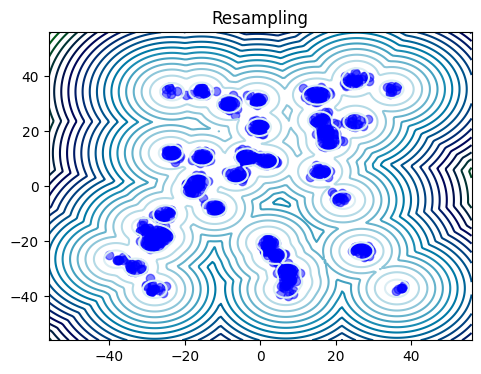

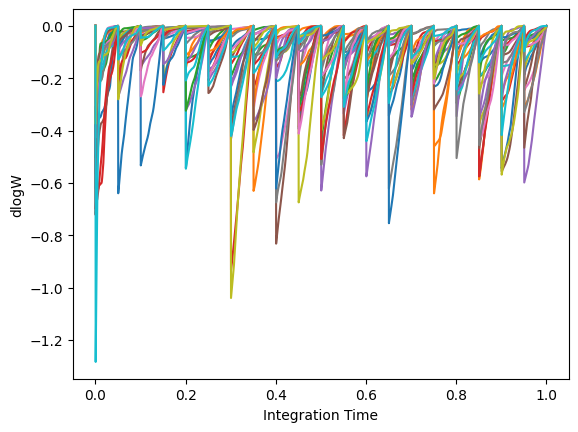

times tensor([0.0000e+00, 5.0000e-04, 1.0000e-03,  ..., 9.9850e-01, 9.9900e-01,
        9.9950e-01], device='cuda:0')


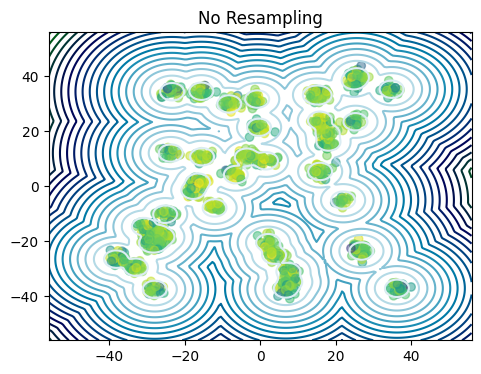

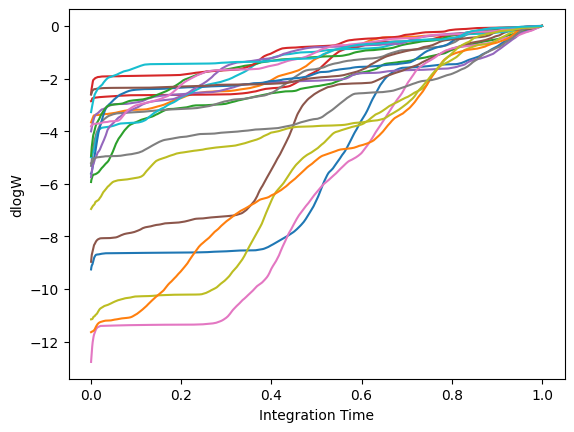

times tensor([0.0000e+00, 5.0000e-04, 1.0000e-03,  ..., 9.9850e-01, 9.9900e-01,
        9.9950e-01], device='cuda:0')


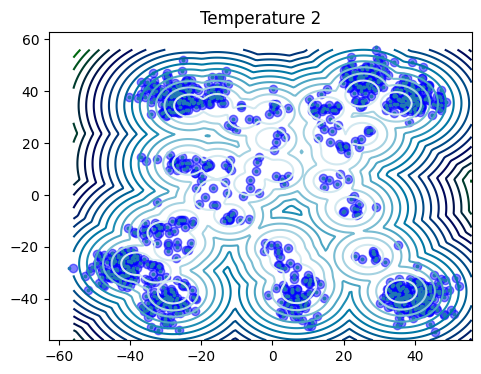

In [62]:
# for plotting

num_int_steps = 2000 

ve_reverse_sde = VEReverse_coupled(noise_schedule)
num_samples = 1000
prior_samples = prior.sample(num_samples)
annealed_prior_samples = annealed_prior.sample(num_samples)
samples_resampled, log_weights = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=annealed_prior_samples,
                                                 num_integration_steps=num_int_steps,
                                                 resampling_interval=100,
                                                 inverse_temperature=inverse_temperature)
target.get_dataset_fig(target.unnormalize(samples_resampled), T=inverse_temperature,
                       title="Resampling")
plt.show()

plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")
plt.ylabel("dlogW")
plt.show()


samples_not_resampled, log_weights = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=annealed_prior_samples,
                                                               num_integration_steps=num_int_steps,
                                                               resampling_interval=num_int_steps+1,
                                                               inverse_temperature=inverse_temperature)
target.get_dataset_fig(target.unnormalize(samples_not_resampled), T=inverse_temperature, color=log_weights.cpu()[-1],
                       title="No Resampling")
plt.show()
plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")
plt.ylabel("dlogW")
plt.show()

# Generate samples at high temprature
ve_reverse_sde = VEReverse_coupled(noise_schedule)
samples_hightemp, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=num_int_steps,
                                                resampling_interval=None, num_samples=num_samples, inverse_temperature=1.0,
                                                samples=prior_samples)
samples_energy = target(samples_hightemp)
target.get_dataset_fig(target.unnormalize(samples_hightemp), T=1.0, title=f"Temperature {temperature}")
samples_hightemp_unnorm = target.unnormalize(samples_hightemp).detach().cpu().numpy()
plt.scatter(samples_hightemp_unnorm[:, 0], samples_hightemp_unnorm[:, 1], s=3)
plt.show()


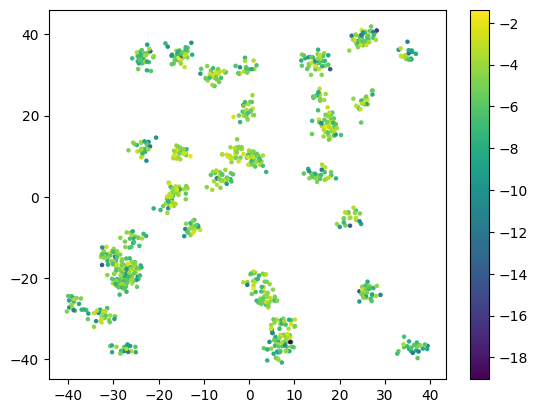

In [40]:
plt.scatter(target.unnormalize(samples_not_resampled)[:, 0].detach().cpu(),
            target.unnormalize(samples_not_resampled)[:, 1].detach().cpu(), s=5,
            c=log_weights[-1].detach().cpu())
plt.colorbar()

Text(0, 0.5, 'Standard Deviation of dlogW')

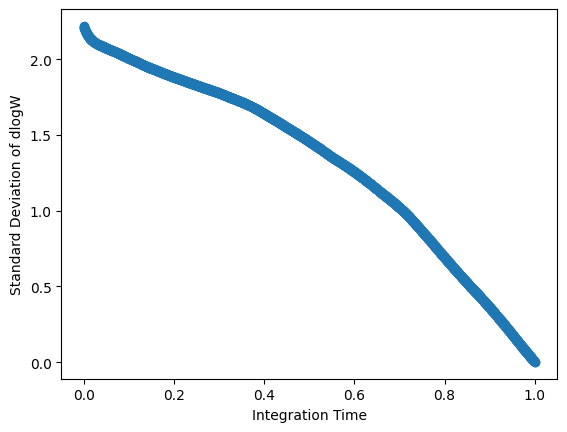

In [41]:
plt.scatter(torch.linspace(1, 0, num_int_steps), log_weights.std(-1).cpu())
plt.xlabel("Integration Time")
plt.ylabel("Standard Deviation of dlogW")

### Metrics

In [42]:
from src.models.components.distribution_distances import eot
from src.models.components.mmd import linear_mmd2, mix_rbf_mmd2, poly_mmd2
from src.models.components.optimal_transport import wasserstein
import ot as pot

def compute_sample_based_metrics(a, b, a_energy, b_energy):
    w1 = wasserstein(a.double(), b.double(), power=1)
    w2 = wasserstein(a.double(), b.double(), power=2)
    mmd_rbf = mix_rbf_mmd2(a, b, sigma_list=10 ** np.linspace(-2, 0, 10)).item()

    H_b, x_b, y_b = np.histogram2d(b[:, 0].cpu().numpy(), b[:, 1].cpu().numpy(), bins=200)
    H_a, x_a, y_a = np.histogram2d(a[:, 0].cpu().numpy(), a[:, 1].cpu().numpy(), bins=(x_b, y_b))
    total_var = 0.5 * np.abs(H_a/H_a.sum() - H_b/H_b.sum()).sum()

    energy_w2 = pot.emd2_1d(
    a_energy,
    b_energy,
    ).detach().cpu().item()
    return w1, w2, mmd_rbf, total_var, energy_w2

In [43]:
target_temp1 = GMM(dimensionality=dimensionality,
                   n_mixes=40,
                   loc_scaling= 40,
                   log_var_scaling=1.0,
                   device=device,
                   should_unnormalize=False,
                   temperature=1.0
                   )

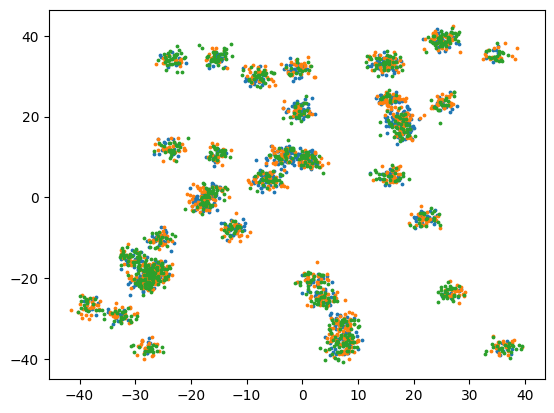

In [44]:
test_samples = target_temp1.sample_test_set(1000)
samples_resampled = samples_resampled.detach()
samples_not_resampled = samples_not_resampled.detach()

samples_resampled = target_temp1.unnormalize(samples_resampled)
samples_not_resampled = target_temp1.unnormalize(samples_not_resampled)

plt.scatter(samples_resampled[:, 0].cpu(), samples_resampled[:, 1].cpu(), s=3)
plt.scatter(test_samples[:, 0].cpu(), test_samples[:, 1].cpu(), s=3)
plt.scatter(samples_not_resampled[:, 0].cpu(), samples_not_resampled[:, 1].cpu(), s=3)
plt.show()

In [45]:
samples = {}
energies = {}


samples["resampled"] = samples_resampled
samples["not_resampled"] = samples_not_resampled
samples["Test"] = test_samples.detach()


for key in samples.keys():
    energies[key] = target_temp1(samples[key]).detach()

In [46]:
data_df = []
metrics= ["W1", "W2", "MMD", "Total Var", "Energy W2"]
for key in samples.keys():
    if key == "Test":
        continue
    
    data_df.append([key, *compute_sample_based_metrics(samples[key], samples["Test"],
                                                       energies[key], energies["Test"])])

In [47]:
import pandas as pd
df = pd.DataFrame(data_df)
df.columns = ["Method"] + metrics

In [48]:
df

,Method,W1,W2,MMD,Total Var,Energy W2
0,resampled,4.854697,7.513984,0.023023,0.835000,0.047853
1,not_resampled,2.575822,4.663053,0.020447,0.824931,0.005647


In [37]:
df

,Method,W1,W2,MMD,Total Var,Energy W2
0,resampled,3.669501,5.926077,0.023400,0.859838,0.466240
1,not_resampled,18.451742,20.457950,0.031104,0.949189,310.802826
